# LE-SDE Plots

Jiayao Zhang Apr 16

In [14]:
from __future__ import print_function, absolute_import, division

%load_ext autoreload
%autoreload 2
# general imports
import sys, os, json, requests, time, datetime, logging, multiprocessing
from pathlib import Path
import pandas as pd
import numpy as np
import functools


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# configs for plots
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from matplotlib import rc # this is the matplotlib suggestion
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (8., 8.0)
sns.set_style("darkgrid")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette('deep')


In [16]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=
%env OMP_NUM_THREADS=3
%env OPENBLAS_NUM_THREADS=3
%env OPENMP_NUM_THREADS=3
%env MKL_NUM_THREADS=3
%env HF_HOME=/shared/zjiayao/cache

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=
env: OMP_NUM_THREADS=3
env: OPENBLAS_NUM_THREADS=3
env: OPENMP_NUM_THREADS=3
env: MKL_NUM_THREADS=3
env: HF_HOME=/shared/zjiayao/cache


In [17]:
EXP_DIR = Path('./exp_data')

## Load Data

In [18]:
def df_to_logits(df, n_c):
    """
    compute $\bar{X}^k$ from training history (in record form)
    """
    dfs = [df[df.y == c][['trial', 'itr', f'y_logit{c}']].astype({"trial": int, "itr": int}) for c in range(n_c)]
    df_logits = functools.reduce(lambda df1, df2 : pd.merge(df1, df2, how='outer', on=['trial','itr']), dfs)
    return pd.melt(df_logits, id_vars=['trial', 'itr'], value_vars=[f'y_logit{c}' for c in range(n_c)]).rename(columns={
        'variable':'Class', 'value':'Logit'
    })

def df_add_smp(df, n):
    df['n'] = n
    return df.astype({"n": str})

def merge_hists(hists, n_c, n_smps, class_labels):
    def d_with_col(h, n):
        h['n'] = n
        for c, y in enumerate(class_labels):
            h.loc[h['Class']==f'y_logit{c}', 'cls'] = c
            h.loc[h['Class']==f'y_logit{c}', 'Class'] = fr'Class {c} ({y})'
        return h.astype({"cls": int, "n": str})
    return pd.concat([d_with_col(h, n)  for (h, n) in zip(hists, n_smps)])
        

In [19]:
n_classes = 3
n_smps = [50, 100, 300, 600, 1000, 3000, 6000]
class_labels = ['Ellipsoid', 'Rectangle', 'Triangle']
base_name = 'geom'

In [20]:
# histories = [df_add_smp(pd.read_csv(EXP_DIR / f'cifar_3class_1000_it10k_l{n_smp}.csv'), n_smp) for n_smp in n_smps]
histories = [df_add_smp(pd.read_csv(EXP_DIR / f'{base_name}_K3_m{n_smp}_it10k_l0.005.csv'),n_smp) for n_smp in n_smps]
hists_m = merge_hists([df_to_logits(h, n_classes) for h in histories], n_classes, n_smps, class_labels)
hists = pd.concat(histories)

In [21]:
# training history
hists.head()

,trial,itr,smp,y,y_logit0,y_logit1,y_logit2,tr_loss,val_loss,val_acc,n
0,0,0,41,1,0.072952,-0.014568,0.072697,1.157715,1.100535,0.333333,50
1,0,1,119,2,0.073674,-0.011016,0.077506,1.068654,1.100613,0.333333,50
2,0,2,56,1,0.066343,-0.012422,0.078028,1.155817,1.100518,0.333333,50
3,0,3,56,1,0.063717,-0.006888,0.075600,1.150301,1.100437,0.333333,50
4,0,4,96,2,0.063208,-0.000352,0.071473,1.072427,1.100489,0.333333,50


In [22]:
# the ``Logit'' column is $\bar{X}^k$
hists_m.head()

,trial,itr,Class,Logit,n,cls
0,0,7,Class 0 (Ellipsoid),0.044198,50,0
1,0,8,Class 0 (Ellipsoid),0.053813,50,0
2,0,15,Class 0 (Ellipsoid),0.039209,50,0
3,0,20,Class 0 (Ellipsoid),0.039640,50,0
4,0,26,Class 0 (Ellipsoid),0.028422,50,0


## Plots

In [23]:
def viz_dyn_cls(hists, y='Logit', c=None, hue=None, style=None, ns=None, figsize=(10,8),
                ylim=None, itrs=None, figname=None, palette=None,
                ltitle=None, ylb=None, xlb=None):
    dat = hists
    if c is not None:
        c = np.array([c]).reshape(-1)
        dat = dat[dat['cls'].isin(c)]
    if itrs is not None:
        dat = dat[dat.itr.isin(itrs)]
    if ns is not None:
        dat = dat[dat.n.isin([str(n) for n in ns])]
        dat.n = dat.n.astype(int)
        
    plt.figure(figsize=figsize)
    ax = plt.gca()

    sns.lineplot(x='itr', y=y, hue=hue, style=style, data=dat, ax=ax, palette=palette)

    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    if xlb is not None:
        plt.xlabel(xlb, size=24)
    if ylb is not None:
        plt.ylabel(ylb, size=24)
    plt.legend(fontsize=18, title=ltitle).get_title().set_fontsize(24)
    plt.tight_layout();
    if ylim is not None:
        plt.ylim(ylim)
    if figname is not None:
        plt.savefig(f'figs/{figname}', bbox_inches='tight')


In [24]:
# when plotting against iterations, do a subsampling
plt_itrs = np.hstack([np.arange(0,100,10), np.arange(100,2000,50), np.arange(2000,10000,100)]).astype(int)

In [25]:
sns.set_palette('coolwarm', n_colors=len(n_smps))
## other choices:
# sns.set_palette("husl")
# sns.set_palette("PuBuGn_d")
# sns.set_palette('deep')
# sns.set_palette('pastel')


## Sanity check

In [26]:
df=hists.groupby([ 'n', 'itr', 'y']).mean()\
    .reset_index()

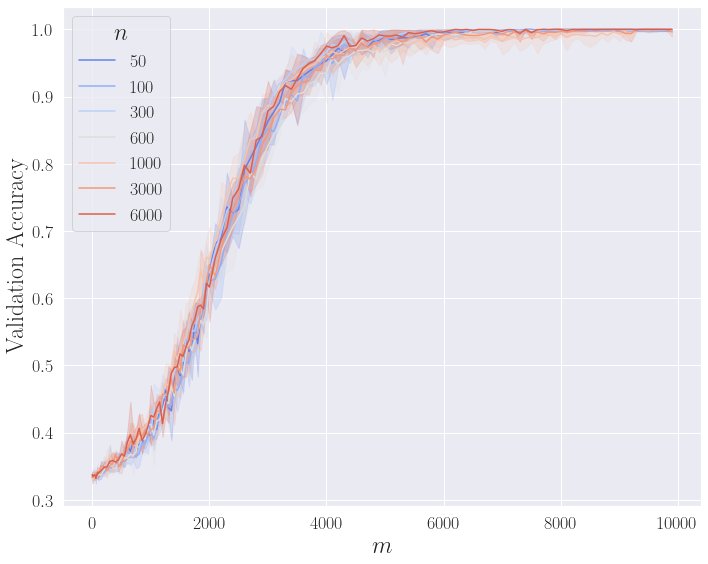

In [27]:
viz_dyn_cls(df, y='val_acc', c=None, hue='n', itrs=plt_itrs, ns=n_smps, ltitle=r'$n$',
            xlb=r'$m$', ylb='Validation Accuracy',
            #figname='geom_val_loss.pdf',
            palette=dict(zip(n_smps, sns.color_palette('coolwarm', n_colors=len(n_smps))))
           )

Here we do a moving averaging using Gaussian window to reduce noises.
Also tried smaller window size and other weighting functions, no significant differences.

In [28]:
df=hists.groupby([ 'n', 'itr', 'y']).mean()\
    .groupby(level='n') \
    .apply(lambda x: x.rolling(window=90, win_type='gaussian').mean(std=30)) \
    .reset_index()


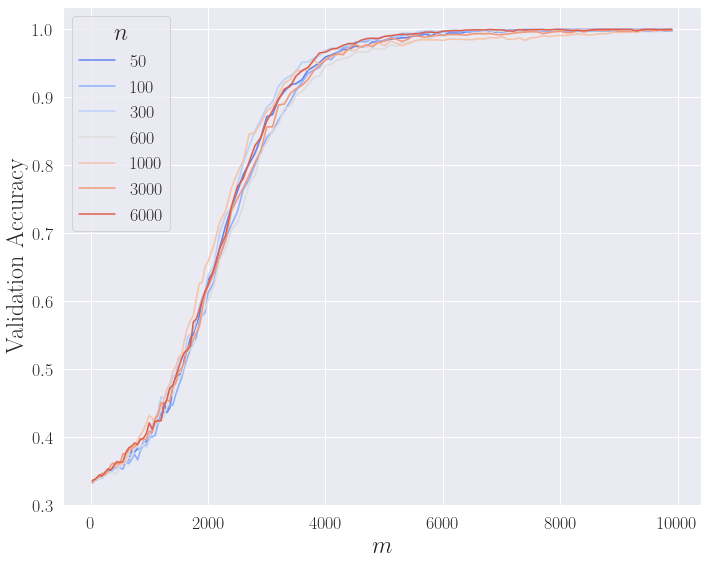

In [29]:
viz_dyn_cls(df, y='val_acc', c=None, hue='n', itrs=plt_itrs, ns=n_smps, ltitle=r'$n$',
            xlb=r'$m$', ylb='Validation Accuracy',
            #figname='geom_val_loss.pdf',
            palette=dict(zip(n_smps, sns.color_palette('coolwarm', n_colors=len(n_smps))))
           )

## Estimating $\lambda_1$

In [30]:
nanmean = lambda x : np.nanmean(np.ma.masked_invalid(x))

def diff(arr):
    return (arr[2:] - arr[:-2]) / 2

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [31]:
df=hists_m.groupby([ 'cls', 'n', 'itr']).mean()\
    .groupby(level=['cls', 'n']).Logit \
    .apply(lambda x: x.rolling(window=90, win_type='gaussian', min_periods=1).mean(std=30)) \
    .reset_index()

First compute $K \bar{x}(t)$, which is the sum of logits grouped by iteration (``itr``) and trial (``n``).

In [33]:
T_it = 10000

dt = df[df.itr < T_it].sort_values(by=['n','itr'])
dt = dt.groupby(['n', 'itr']).sum().reset_index()


Then using the tail of $K\bar{x}(t)$ (after itereation ``4000``) to esimate $\lambda_1$ and the integrated error $E(t)$.

In [34]:
yss = [np.array(dt[(dt['cls']==3) & (dt.n==f'{n}')].Logit) for n in n_smps]
ld1=[nanmean( np.log(ys[1:]/ys[:-1])[4000:] )  for ys in yss]
Es = [yss[idx]/ 3. / np.exp(ld1[idx] * np.arange(T_it)) -yss[idx][0]/3 for idx,n in enumerate(n_smps)]

<ipython-input-34-536669d75fdd>:2: RuntimeWarning: invalid value encountered in log
  ld1=[nanmean( np.log(ys[1:]/ys[:-1])[4000:] )  for ys in yss]


### Plots of logits $\bar{X}^{(k)}$

In [37]:
ylim = [-2, 14]

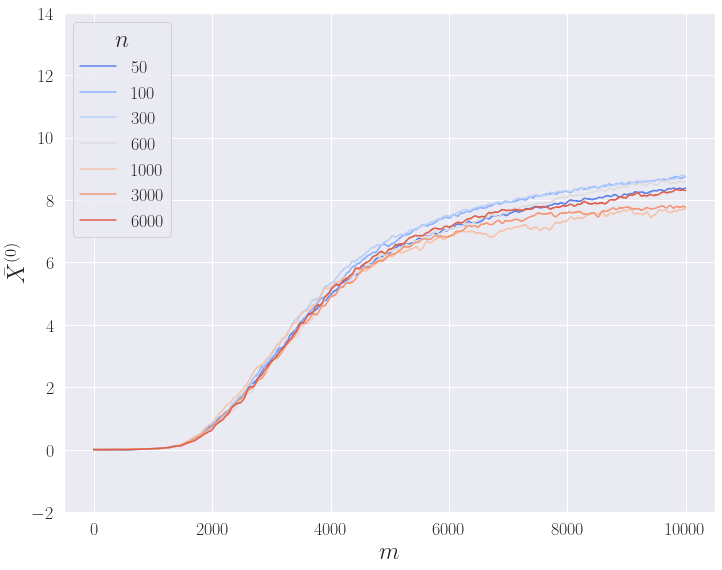

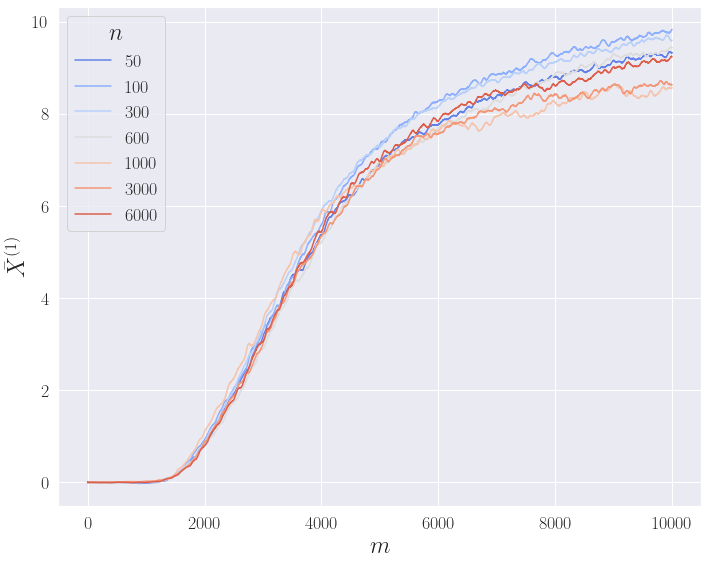

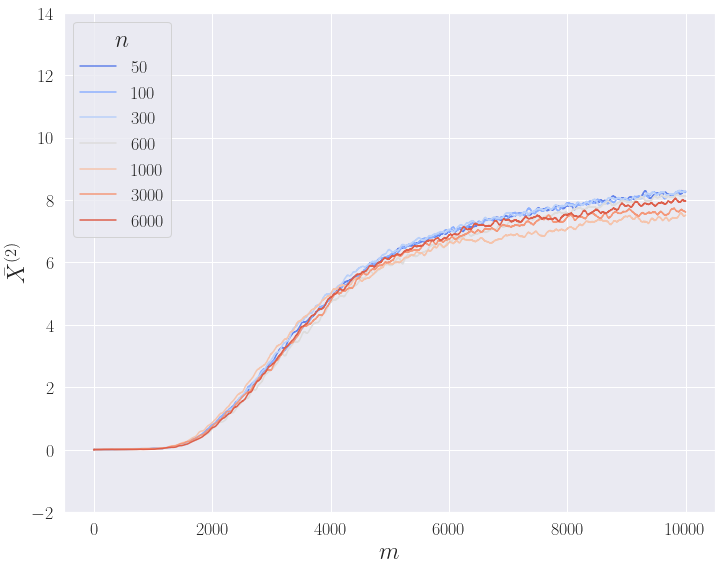

In [39]:
viz_dyn_cls(df[df.cls==0], y='Logit',  hue='n', ns=n_smps,
#             figname='Xbar0_m.pdf',
            palette = dict(zip(n_smps, sns.color_palette('coolwarm', n_colors=len(n_smps)))),
            ltitle=r'$n$', ylb=r'$\bar{X}^{(0)}$', xlb=r'$m$', ylim=ylim,
           )
viz_dyn_cls(df[df.cls==1], y='Logit',  hue='n', ns=n_smps,
#             figname='Xbar1_m.pdf',
            palette = dict(zip(n_smps, sns.color_palette('coolwarm', n_colors=len(n_smps)))),
            ltitle=r'$n$', ylb=r'$\bar{X}^{(1)}$', xlb=r'$m$',
           )
viz_dyn_cls(df[df.cls==2], y='Logit',  hue='n', ns=n_smps,
#             figname='Xbar2_m.pdf',
            palette = dict(zip(n_smps, sns.color_palette('coolwarm', n_colors=len(n_smps)))),
            ltitle=r'$n$', ylb=r'$\bar{X}^{(2)}$', xlb=r'$m$', ylim=ylim,
           )

### Plot of the average $\bar{x](t)$

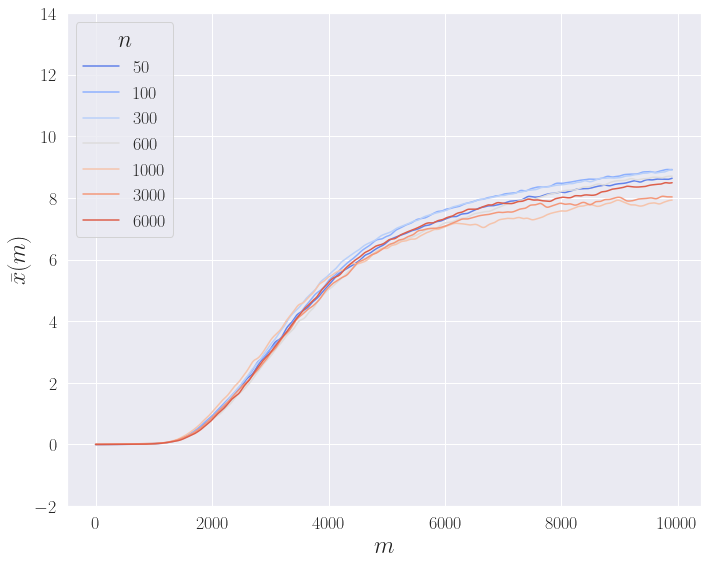

In [40]:
plt.figure(figsize=(10,8))
sns.set_palette('coolwarm', n_colors=len(n_smps))

for idx, ys in enumerate(yss):
    plt.plot(moving_average(ys/3, 100),
             label=f'{n_smps[idx]}')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel(r'$m$', size=24)
plt.ylabel(r'$\bar{x}(m)$', size=24)
plt.ylim(ylim)
plt.legend(fontsize=18, title=r'$n$').get_title().set_fontsize(24)
plt.tight_layout();
# plt.savefig(f'figs/geom_xbar_m.pdf', bbox_inches='tight')


### Plot of the ratio for estimation, $\bar{x}(m+1) / \bar{x}(m)$

<ipython-input-42-daba4e59da27>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),
<ipython-input-42-daba4e59da27>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),
<ipython-input-42-daba4e59da27>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),
<ipython-input-42-daba4e59da27>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),
<ipython-input-42-daba4e59da27>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),


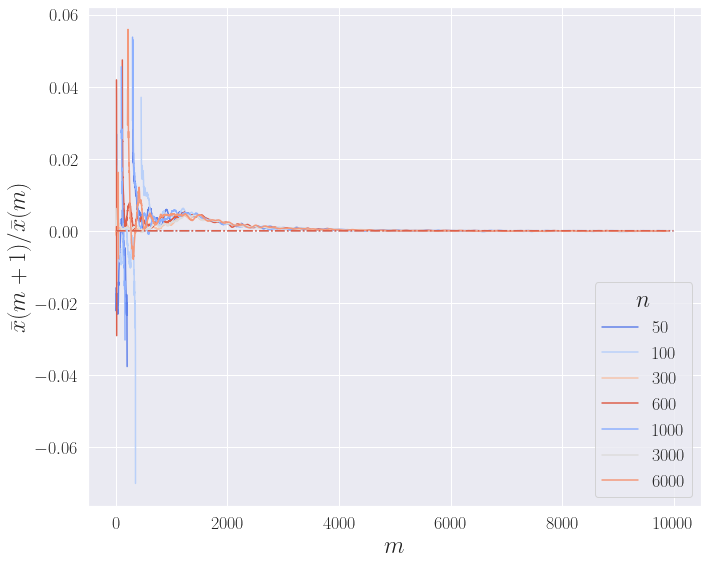

In [42]:
plt.figure(figsize=(10,8))
sns.set_palette('coolwarm', n_colors=len(n_smps))

for idx, ys in enumerate(yss):
    plt.plot(moving_average(np.log(ys[1:]/ys[:-1]), 100),
             label=f'{n_smps[idx]}')
    plt.plot(np.ones(len(moving_average((ys[1:]/ys[:-1]), 2))) * ld1[idx], ls='-.')


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel(r'$m$', size=24)
plt.ylabel(r'$\bar{x}(m+1)/\bar{x}(m)$', size=24)
plt.legend(fontsize=18, title=r'$n$').get_title().set_fontsize(24)
plt.tight_layout();
# plt.savefig(f'figs/geom_ratio_m.pdf', bbox_inches='tight')


### Plot of the integrated error $E(t)$

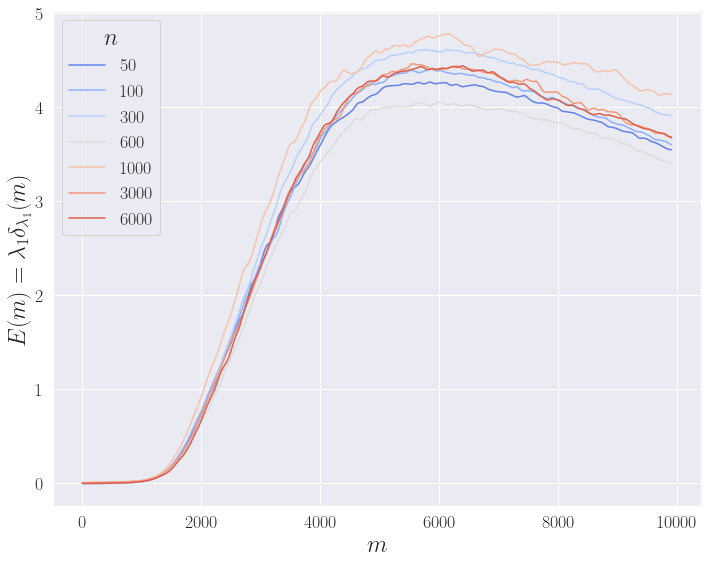

In [43]:
plt.figure(figsize=(10,8))
sns.set_palette('coolwarm', n_colors=len(n_smps))

for idx, ys in enumerate(yss):
    plt.plot(moving_average(Es[idx], 100), label=f'{n_smps[idx]}')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel(r'$m$', size=24)
plt.ylabel(r'$E(m)=\lambda_1\delta_{\lambda_1}(m)$', size=24)
plt.legend(fontsize=18, title=r'$n$').get_title().set_fontsize(24)
plt.tight_layout();
plt.savefig(f'figs/geom_E_m.pdf', bbox_inches='tight')


### Plot of the error/residue $\epsilon(t)$

#### $\epsilon(m)$ versus $n$

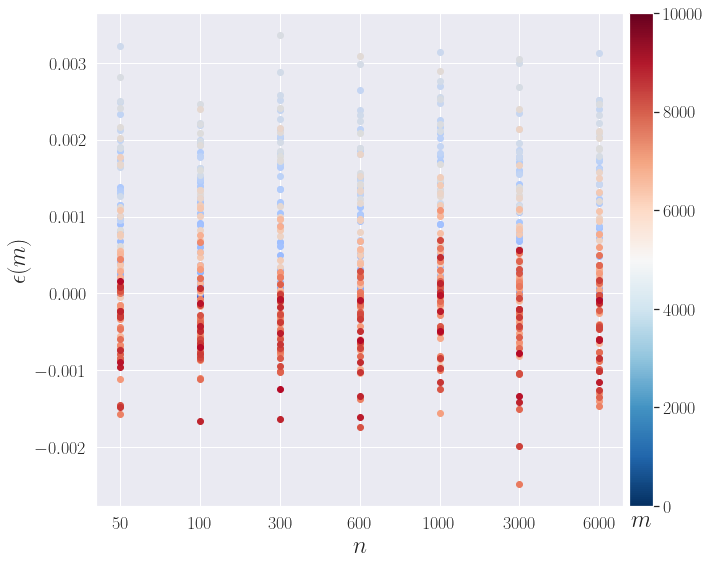

In [46]:
itrs = plt_itrs

sns.set_palette('coolwarm', n_colors=len(itrs))

plt.figure(figsize=(10,8))
for it in itrs:
    plt.scatter([f'{s}' for s in n_smps],
             [moving_average( diff(Es[idx]) * np.exp(ld1[idx] * np.arange(1, T_it-1)), 60)[it] for (idx, n) in enumerate(n_smps)],
               )
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel(r'$n$', size=24)
plt.ylabel(r'$\epsilon(m)$', size=24)
           
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(T_it, 0))
sm.set_array([])
cbar = ax.figure.colorbar(sm, fraction=0.05, pad=0.01, )
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_xlabel(r'$m$', fontsize=24)


plt.tight_layout();
# plt.savefig(f'figs/geom_eps_n.pdf', bbox_inches='tight')


#### $\epsilon(m)$ versus $m$

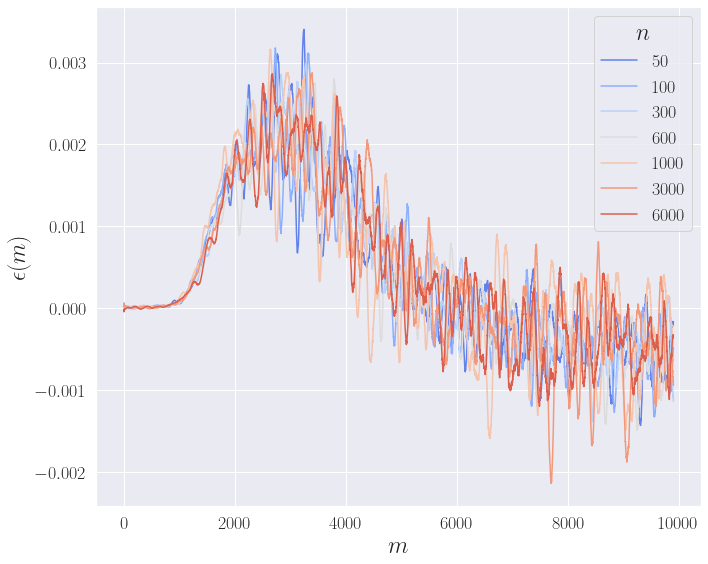

In [47]:
plt.figure(figsize=(10,8))
sns.set_palette('coolwarm', n_colors=len(n_smps))

for idx, ys in enumerate(yss):
    plt.plot(moving_average( diff(Es[idx]) * np.exp(ld1[idx] * np.arange(1, T_it-1)), 100), label=f'{n_smps[idx]}')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel(r'$m$', size=24)
plt.ylabel(r'$\epsilon(m)$', size=24)
plt.legend(fontsize=18, title=r'$n$').get_title().set_fontsize(24)
plt.tight_layout();

# plt.savefig(f'figs/geom_eps_m.pdf', bbox_inches='tight')
